
<center>
<h1> AWS SageMaker </h1>
    <h2>Scalable MLOps using AWS SageMaker </h2>
    <h3>June 23, 2022</h3>
<hr>
<h1>Exploratory Data Analysis</h1>
<hr>
 </center>

# Introduction
We start our journey into MLOps with AWS SageMaker by inspecting the dataset with regards to:

1. Data composition, with regards to structure and quality
2. Associations between the different attributes

Let´s get started...

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import math
import umap

# add path to data

/Users/PhilippWarmer/opt/miniconda3/envs/mlops/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Connecting to the s3 bucket

In [2]:
# add AWS stuff here

## Load data into notebook 

In [3]:
DIR = 'd-one-mlops/data/batch2/2020/'

paths = Path(DIR).rglob('[!.]*.csv')
dfs = []
for path in paths:
    temp = pd.read_csv(path)
    dfs.append(temp)

df = pd.concat(dfs)

## 1. Understanding the data composition
we do this by examining:
* dimension, how many rows and columns?
* fraction of missing data
* datatypes of each attribute

### Data dimensions

In [14]:
print(df.shape)

(104187, 15)


We see that we have 104187 rows.

### Fraction of missing data and datatype per attribute

In [17]:
pd.DataFrame([df.isna().mean(),
df.dtypes]).T.rename({0:'fraction of na', 1:'datatype'}, axis=1)

,fraction of na,datatype
wt_sk,0.0,int64
measured_at,0.0,"datetime64[ns, pytz.FixedOffset(60)]"
wind_speed,0.0,float64
power,0.0,float64
nacelle_direction,0.0,float64
wind_direction,0.0,float64
rotor_speed,0.0,float64
generator_speed,0.0,float64
temp_environment,0.0,float64
temp_hydraulic_oil,0.0,float64


In [18]:
df['measured_at'].head(1)

0   2020-06-06 01:00:00+01:00
Name: measured_at, dtype: datetime64[ns, pytz.FixedOffset(60)]

The data consists of 16 attributes of which 15 are numerical and 1 is a timestamp. There are a total of 104187 entries in this dataset, with no missing data across the feature attributes. 

As this is time series data we wanted to see if the data was homogeniously collected over the time span. Thus we first parsed the 'measured_at' column into a machine readable datetime and plotted the number of rows over time.

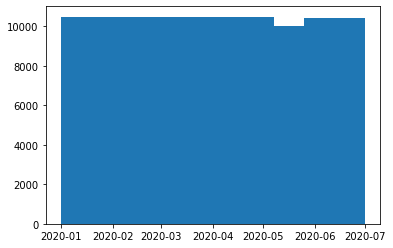

In [19]:
df['measured_at'] = pd.to_datetime(df['measured_at'])

plt.hist(df.measured_at.values)
plt.show()

Great! The data is evenly spread over the sampled time horizon from 2020-01 to 2020-07

Now, we will turn our attention to the numerical features. More specifically, we will look at the number of unique values for each feature.

In [20]:
vals_unique = df.select_dtypes(include="number").nunique().sort_values()
print(vals_unique)

subtraction                2
wt_sk                      4
wind_speed            104187
power                 104187
nacelle_direction     104187
wind_direction        104187
rotor_speed           104187
generator_speed       104187
temp_environment      104187
temp_hydraulic_oil    104187
temp_gear_bearing     104187
cosphi                104187
blade_angle_avg       104187
hydraulic_pressure    104187
dtype: int64


We see that out of the 15 columns 3 are categorical and the other 12 are composed of continuous features since there are 104187 values, one for each row.

The `subtraction` attribute shows the presence of an error and the `categories_sk` attribute descibes the type of error in more depth
Since the aim of this exersice is to showcase this dataset and ultimatly a SageMaker workflow we continue with the `subtraction` attribute and drop the `categories_sk` attribute.

In [9]:
df.drop("categories_sk", axis=1, inplace=True)

# 2. Associations between the different data attributes

Ultimatly we wanted to see the highdimensional structure. We did this by:
   1. z-scoring features excluding the time dimension, turbine number and error code
   2. Collapsing the high dimensional data into 2 dimensions using umap
   3. Highlighting excluded attributes on the 2d representation of the data

/var/folders/g9/c_dttcps3m56h5kkhkdg32wh0000gp/T/ipykernel_17930/503839734.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_plot['error_type'][X_to_plot.error_type.isna()] = 2


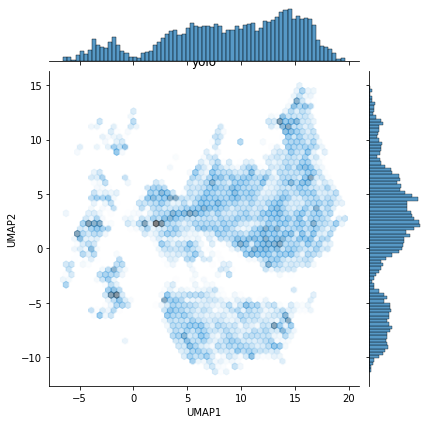

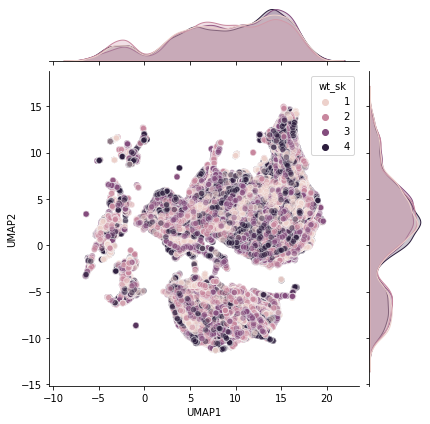

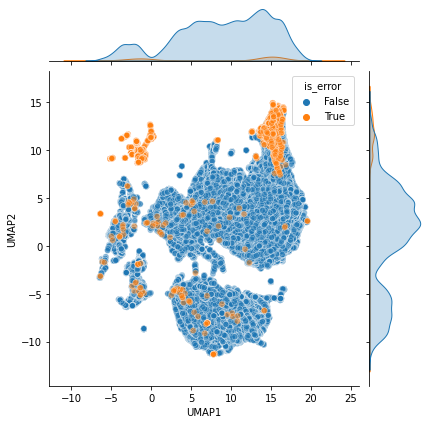

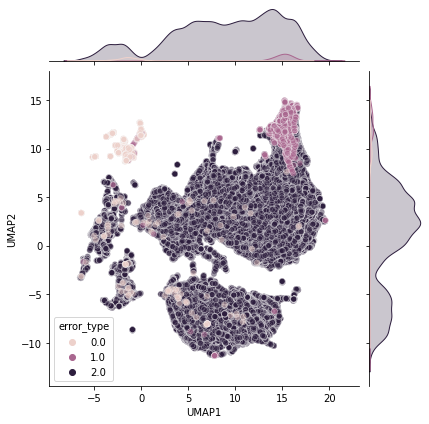

In [21]:
# Split data into labels and features
columns = df.columns.values
y_cols = df.columns.str.contains('wt_sk|subtraction|measured_at')

y = df[list(columns[y_cols])]
X = df[list(columns[~y_cols])]

# 1. Scale features
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

# 2. Get embeddings
embedding = umap.UMAP().fit_transform(X_)

# Curate dataframe for plotting
X_to_plot = pd.DataFrame(embedding, columns=['UMAP1','UMAP2'])
X_to_plot['error_type'] = y['subtraction'].to_list()

# Flag na values with 2 in error type
X_to_plot['error_type'][X_to_plot.error_type.isna()] = 2
X_to_plot['is_error'] = (X_to_plot.error_type != 2)

X_to_plot = X_to_plot.sort_values(by='is_error', ascending=True)

X_to_plot['wt_sk'] = y['wt_sk'].to_list()

sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                kind='hex'
)

sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                hue='wt_sk',
)


sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                hue='is_error',
)


sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                hue='error_type',
)

plt.show()

For the umaps (here labled 1-4) we make the following observations:

1. In the first plot we see that the there is not a single point where most of the data is located but that it is spread across the different dimensions.

2. In the second plot the color indicates the different turbines. Since the colors are equally spread across the dimensions we can assume that there is no strong bias in the data towards one turbine in specific.

3. In the third plot the color indicates wether there is an error or not. We find, as expected, that the errors are mostly located on separated islands with some exceptions where the blue and orange points, corresponding to faulty and working turbines, are mixed.

4. Further looking into the error type we find that the different error types are distinct from each other.

We conclude that we can proceed with training a model on the data